In [21]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [22]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones
from my_metrics import compute_edge_betweenness

In [23]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [24]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???
# Milano                               (Italy)              EPSG:6875 ???
# Ljubljana                            (Slovenia)           EPSG:8687 ???

place_name = 'Ljubljana'
case_name = 'municipality'
local_crs = 'EPSG:8687'

In [25]:
buffer = 500

# Load data

In [26]:
# NL
if local_crs == 'EPSG:28992':
    place = gpd.read_file(os.path.join(output_folder, 'WijkBuurtkaart_2022_v0', 'SHP', 'CBS_buurten2022.shp'))
    
    if case_name == 'West':
        WK_NAAM = 'Wijk 01 West'
        BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM) & (place['BU_NAAM']!=BU_NAAM_exclude)]
        
    elif case_name == 'Zuid West':
        WK_NAAM = 'Wijk 08 Zuidwest'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]
    
    elif case_name == 'Zuid':
        WK_NAAM = 'Wijk 07 Zuid'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]
    
    elif case_name == 'three districts':
        BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM'].isin(['Wijk 01 West', 'Wijk 08 Zuidwest', 'Wijk 07 Zuid'])) & (place['BU_NAAM']!=BU_NAAM_exclude)]

    elif case_name == 'municipality':
        place = place[(place['GM_NAAM']==place_name)]
        
# not NL
else:
    place = ox.geocode_to_gdf(place_name).to_crs(local_crs)

In [27]:
place = gpd.GeoDataFrame(index=[0], crs=local_crs, geometry=[place.unary_union])

<AxesSubplot:>

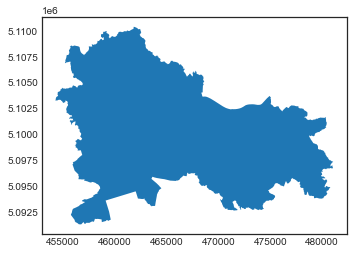

In [28]:
place.plot()

In [29]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### Play spaces

#### playgrounds

In [30]:
# also schoolyards? but this is a rarely used tag, in used, but not formally approved 
# (e.g., in our case study cities, appearing only once, in Ljubljana, but with access=private)
# in practice, schoolyards are tagged as amenity=school, but this tag includes many other types of schools as well
# with the school itself being building=school
# often, when there are play facilities, these are tagged as playground
playgrounds_filter = (f'["leisure"~"playground|schoolyard"]["access"!="private"]')
playgrounds = gpd.clip(get_osm_data(playgrounds_filter, extent, 'convexhull'), extent)

#### natural, type-based

In [31]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=None, max_area=None, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", predicate='within')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area is not None:
        filtered = filtered[filtered.geometry.area>=min_area]
        
    # filter on maximum area
    if max_area is not None:
        filtered = filtered[filtered.geometry.area<=max_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [32]:
# parks
parks_filter = '["leisure"~"^(park)"]'
parks = get_osm_data(parks_filter, extent, 'convexhull')
tipping_point = 50000   
# anything between 25000 and 50000 works for Utrecht West
# for Zuid-West: from 30000 onwards? there is one around 35000 that I'm unsure about though
# for Zuid: ? above seems fine, intuitively, but not discussed during session
# setting on 50000 for now, clear barriers, keeping smaller up for discussion in Milan
parks_small = gpd.clip(greenspace_filter(parks, local_crs, max_area=tipping_point), extent)

#### filter

In [33]:
def no_points(gdf):
    
    if len(gdf):
        filtered = gdf[(gdf.geom_type == 'Polygon')|(gdf.geom_type == 'MultiPolygon')|(gdf.geom_type == 'LineString')|(gdf.geom_type == 'MultiLineString')]
        return filtered
    else:
        return gdf

In [34]:
playgrounds = no_points(playgrounds)
parks_small = no_points(parks_small)

#### plots

In [35]:
playgrounds['geometry_buffer'] = playgrounds.geometry.buffer(100)
parks_small['geometry_buffer'] = parks_small.geometry.buffer(100)

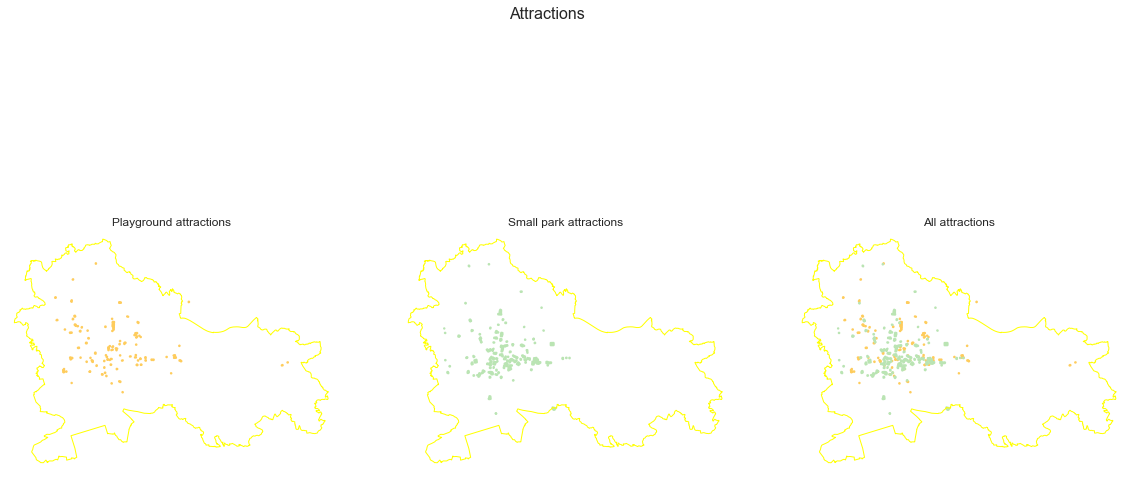

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
fig.suptitle('Attractions', fontsize=16)


barrier_width = 3
    
# orange
playgrounds.set_geometry('geometry_buffer').plot(ax=axs[0], color='#fecc5c', linewidth=barrier_width, zorder=1)
axs[0].set_title('Playground attractions')

# green
parks_small.set_geometry('geometry_buffer').plot(ax=axs[1], color='#bae4b3', linewidth=barrier_width, zorder=1)
axs[1].set_title('Small park attractions')

# all combined
playgrounds.set_geometry('geometry_buffer').plot(ax=axs[2], color='#fecc5c', linewidth=barrier_width, zorder=1)
parks_small.set_geometry('geometry_buffer').plot(ax=axs[2], color='#bae4b3', linewidth=barrier_width, zorder=1)
axs[2].set_title('All attractions')


for ax in axs:
    place.plot(ax=ax, facecolor='none', edgecolor='yellow', linestyle='-', linewidth=1, zorder=1)
    
    bbox = place.total_bounds
    margin = 600
    xlim = ([bbox[0]-margin, bbox[2]+margin])
    ylim = ([bbox[1]-margin, bbox[3]+margin])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')

    
plt.show()

#  Store output data

In [37]:
place_name_out = (place_name + '_' + case_name).split(',')[0].replace(' ', '')
today = datetime.date.today().strftime("%d%b%Y")
output_sub_folder = os.path.join(output_folder, '{}_{}'.format(place_name_out, today))

In [38]:
output_sub_folder

'data/Ljubljana_municipality_09Nov2022'

In [39]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [40]:
output_file = os.path.join(output_sub_folder, 'playground_attraction.geojson')
playgrounds_out = playgrounds.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playgrounds_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'small_park_attraction.geojson')
parks_small_out = parks_small.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
parks_small_out.to_file(output_file, driver='GeoJSON')